In [1]:
# !pip install wandb

In [2]:
# import wandb
# # wandb.init(config=args)a

In [5]:
try:
    import mlagents
    from mlagents_envs.environment import UnityEnvironment as UE
    from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
    print("ml-agents already installed")
except ImportError:
#     !pip install mlagents==0.26.0
    print("Installed ml-agents")

ml-agents already installed


In [11]:
import torch
from typing import Tuple
from math import floor


class VisualQNetwork(torch.nn.Module):
  def __init__(
    self,
    input_shape: Tuple[int], 
    encoding_size: int, 
    output_size: int
  ):
    """
    Creates a neural network that takes as input a batch of images (3
    dimensional tensors) and outputs a batch of outputs (1 dimensional
    tensors)
    """
    super(VisualQNetwork, self).__init__()
#     height = input_shape[0]
#     width = input_shape[1]
#     initial_channels = input_shape[2]
#     conv_1_hw = self.conv_output_shape((height, width), 8, 4)
#     conv_2_hw = self.conv_output_shape(conv_1_hw, 4, 2)
#     self.final_flat = conv_2_hw[0] * conv_2_hw[1] * 32
    
    
#     self.conv1 = torch.nn.Conv2d(initial_channels, 16, [8, 8], [4, 4])
#     self.conv2 = torch.nn.Conv2d(16, 32, [4, 4], [2, 2])
#     self.dense1 = torch.nn.Linear(self.final_flat, encoding_size)

    
    self.dense1 = torch.nn.Linear(input_shape[0], encoding_size)
    self.dense2 = torch.nn.Linear(encoding_size, encoding_size)
    
    self.dense2_x1 = torch.nn.Linear(encoding_size, output_size)
    self.dense2_x2 = torch.nn.Linear(encoding_size, output_size)
    self.dense2_x3 = torch.nn.Linear(encoding_size, output_size)
   
    self.act = torch.nn.Sigmoid() # ReLU

    
    
  def forward(self, visual_obs: torch.tensor):
#     print("torch input size:", visual_obs.size())
#     visual_obs = visual_obs.permute(0, 3, 1, 2)
#     conv_1 = torch.relu(self.conv1(visual_obs))
#     conv_2 = torch.relu(self.conv2(conv_1))
#     hidden = self.dense1(conv_2.reshape([-1, self.final_flat]))

    hidden = self.dense1(visual_obs)
    hidden = self.act(hidden)

    hidden = self.dense2(hidden)
    hidden = self.act(hidden)

    x1 = self.dense2_x1(hidden)
    x1 = self.act(x1)
    x2 = self.dense2_x2(hidden)
    x2 = self.act(x2)
    x3 = self.dense2_x3(hidden)
    x3 = self.act(x3)

    return x1, x2, x3

  @staticmethod
  def conv_output_shape(
    h_w: Tuple[int, int],
    kernel_size: int = 1,
    stride: int = 1,
    pad: int = 0,
    dilation: int = 1,
  ):
    """
    Computes the height and width of the output of a convolution layer.
    """
    h = floor(
      ((h_w[0] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    w = floor(
      ((h_w[1] + (2 * pad) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
    )
    return h, w


In [12]:
import numpy as np
from typing import NamedTuple, List


class Experience(NamedTuple):
  """
  An experience contains the data of one Agent transition.
  - Observation
  - Action
  - Reward
  - Done flag
  - Next Observation
  """

  obs: np.ndarray
  action: np.ndarray
  reward: float
  done: bool
  next_obs: np.ndarray

# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience]

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = List[Experience]

In [13]:
from mlagents_envs.environment import ActionTuple, BaseEnv
from typing import Dict
import random


class Trainer:
  @staticmethod
  def generate_trajectories(
    env: BaseEnv, q_net: VisualQNetwork, buffer_size: int, epsilon: float
  ):
    """
    Given a Unity Environment and a Q-Network, this method will generate a
    buffer of Experiences obtained by running the Environment with the Policy
    derived from the Q-Network.
    :param BaseEnv: The UnityEnvironment used.
    :param q_net: The Q-Network used to collect the data.
    :param buffer_size: The minimum size of the buffer this method will return.
    :param epsilon: Will add a random normal variable with standard deviation.
    epsilon to the value heads of the Q-Network to encourage exploration.
    :returns: a Tuple containing the created buffer and the average cumulative
    the Agents obtained.
    """
    # Create an empty Buffer
    buffer: Buffer = []

    # Reset the environment
    env.reset()
    # Read and store the Behavior Name of the Environment
    behavior_name = list(env.behavior_specs)[0]
    # Read and store the Behavior Specs of the Environment
    spec = env.behavior_specs[behavior_name]

    # Create a Mapping from AgentId to Trajectories. This will help us create
    # trajectories for each Agents
    dict_trajectories_from_agent: Dict[int, Trajectory] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_obs_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to the last observation of the Agent
    dict_last_action_from_agent: Dict[int, np.ndarray] = {}
    # Create a Mapping from AgentId to cumulative reward (Only for reporting)
    dict_cumulative_reward_from_agent: Dict[int, float] = {}
    # Create a list to store the cumulative rewards obtained so far
    cumulative_rewards: List[float] = []
    
    
    entered_terminal = False
    while len(buffer) < buffer_size:  # While not enough data in the buffer
      # Get the Decision Steps and Terminal Steps of the Agents
      decision_steps, terminal_steps = env.get_steps(behavior_name)
    
        # For all Agents with a Terminal Step:
      for agent_id_terminated in terminal_steps:
#         print("entered agent with terminal step")
#         print(agent_id_terminated)

        # Create its last experience (is last because the Agent terminated)
        last_experience = Experience(
          obs=dict_last_obs_from_agent[agent_id_terminated].copy(),
          reward=terminal_steps[agent_id_terminated].reward,
          done=not terminal_steps[agent_id_terminated].interrupted,
          action=dict_last_action_from_agent[agent_id_terminated].copy(),
          next_obs=terminal_steps[agent_id_terminated].obs[0],
        )
        # Clear its last observation and action (Since the trajectory is over)
        dict_last_obs_from_agent.pop(agent_id_terminated)
        dict_last_action_from_agent.pop(agent_id_terminated)
        # Report the cumulative reward
        cumulative_reward = (
          dict_cumulative_reward_from_agent.pop(agent_id_terminated)
          + terminal_steps[agent_id_terminated].reward
        )
#         print("cumulative reward: ", cumulative_reward)
        cumulative_rewards.append(cumulative_reward) #  - 50
        # Add the Trajectory and the last experience to the buffer
        buffer.extend(dict_trajectories_from_agent.pop(agent_id_terminated))
        buffer.append(last_experience)
        entered_terminal = True

      # For all Agents with a Decision Step:
      for agent_id_decisions in decision_steps:
        # If the Agent does not have a Trajectory, create an empty one
        if agent_id_decisions not in dict_trajectories_from_agent:
          dict_trajectories_from_agent[agent_id_decisions] = []
          dict_cumulative_reward_from_agent[agent_id_decisions] = 0

        # If the Agent requesting a decision has a "last observation"
        if agent_id_decisions in dict_last_obs_from_agent:
          # Create an Experience from the last observation and the Decision Step
          exp = Experience(
            obs=dict_last_obs_from_agent[agent_id_decisions].copy(),
            reward=decision_steps[agent_id_decisions].reward, #  - 0.05
            done=False,
            action=dict_last_action_from_agent[agent_id_decisions].copy(),
            next_obs=decision_steps[agent_id_decisions].obs[0],
          )
          # Update the Trajectory of the Agent and its cumulative reward
          dict_trajectories_from_agent[agent_id_decisions].append(exp)
          dict_cumulative_reward_from_agent[agent_id_decisions] += (
            decision_steps[agent_id_decisions].reward
          )
        # Store the observation as the new "last observation"
        dict_last_obs_from_agent[agent_id_decisions] = (
          decision_steps[agent_id_decisions].obs[0]
        )

      # Generate an action for all the Agents that requested a decision
      # Compute the values for each action given the observation    
      act1, act2, act3 = q_net(torch.from_numpy(decision_steps.obs[0]))
    
      if len(decision_steps) == 0:
#             print("error: no more observations ! ")
            env.step()
            continue
#       if act1.size == 0:
#             print("error: Action space received = 0")
#             env.step()
#             continue
            
      # get actions as arrays
      act1 = act1.detach().numpy()
      act2 = act2.detach().numpy()
      act3 = act3.detach().numpy()
    
#       print("action received from QNetwork: ", act1)
#       print("action received from QNetwork: ", act2)
#       print("action received from QNetwork: ", act3)
      act1 += epsilon * np.random.randn(act1.shape[0], act1.shape[1]).astype(np.float32)
      act2 += epsilon * np.random.randn(act1.shape[0], act1.shape[1]).astype(np.float32)
      act3 += epsilon * np.random.randn(act1.shape[0], act1.shape[1]).astype(np.float32)
      
      # pick the best action using argmax
      act1 = np.argmax(act1, axis=1)
      act2 = np.argmax(act2, axis=1)
      act3 = np.argmax(act3, axis=1)
#       print("action received from argmax: ", act1)
#       print("action received from argmax: ", act1.shape)
#       act1 = np.array([act1])
#       act2 = np.array([act2])
#       act3 = np.array([act3])
      act1 = np.expand_dims(act1, axis=1)
      act2 = np.expand_dims(act2, axis=1)
      act3 = np.expand_dims(act3, axis=1)
#       print("action received from argmax expanded: ", act1)
#       print("action received from argmax expanded: ", act1.shape)

      # map action index 2 to -1 for the agent to move backwards, left, and rotate left
      act1[act1 > 1] = -1
      act2[act2 > 1] = -1
      act3[act3 > 1] = -1

      # format to numpy arrays
#       print("action received from mapping: ", act1)
#       try:
# #         actions_values = np.array([act1, act2, act3]).reshape(3,3)
#         actions_values = np.vstack((act1, act2, act3))
#       except:
#         actions_values = np.zeros((3,3))
#         print("error: network received an input of size 0 and i caught the error :/")

        #      0-8nt(type(actions_values))
    
    
#       actions =  np.vstack((act1, act2, act3))
#       actions =  np.vstack((act1, act2, act3))

      temp = np.hstack((act1, act2, act3))
#       print("actions stacked with hstack:", temp)
#       print("actions stacked with hstack: shape:", temp.shape)
#       temp = np.concatenate((act1, act2, act3), axis=1)
#       print("actions stacked with concat:", temp)
#       print("actions stacked with concat: shape:", temp.shape)
        
#       actions_values = np.zeros((3,3))
#       # Add some noise with epsilon to the values
#       actions_values += epsilon * np.random.randn(actions_values.shape[0], actions_values.shape[1]).astype(np.float32)
#       actions = np.argmax(actions_values, axis=1)
      
      actions = temp
#       print("final actions: ", actions)
#       print("final actions shape: ", actions.shape)
      actions.resize((len(decision_steps), 3))
#       print("decision steps size:", len(decision_steps))
#       print("final actions after resize: ", actions)
#       print("final actions shape: ", actions.shape)


      # Store the action that was picked, it will be put in the trajectory later
      for agent_index, agent_id in enumerate(decision_steps.agent_id):
        dict_last_action_from_agent[agent_id] = actions[agent_index]
#       print("dict last action: ", dict_last_action_from_agent)

        
      # Set the actions in the environment
      # Unity Environments expect ActionTuple instances.
      action_tuple = ActionTuple()
      action_tuple.add_discrete(actions)
#       print("filtered action received from QNetwork: ", action_tuple.discrete)
      env.set_actions(behavior_name, action_tuple)
      # Perform a step in the simulation
      env.step()
    return buffer, np.mean(cumulative_rewards)

  @staticmethod
  def update_q_net(
    q_net: VisualQNetwork, 
    optimizer: torch.optim, 
    buffer: Buffer, 
    action_size: int
  ):
    """
    Performs an update of the Q-Network using the provided optimizer and buffer
    """
    def calculate_bellman_loss(next_pred_action, pred_action, reward, done, GAMMA, batch, action_size, action):
        # Use the Bellman equation to update the Q-Network
        target = (
          reward
          + (1.0 - done)
          * GAMMA
          * torch.max(next_pred_action.detach(), dim=1, keepdim=True).values
        ).double()
#         print("next_act_prediction:", next_pred_action.detach().numpy())
        
#         print("Target:", target)
#         print("Target shape:", target.shape)

#         print("action:", action)
#         print("action shape: ", action.shape)
        assert(action.shape[0] == len(batch))
        action[action < 0] = 2
#         print("action after correction:", action)
        
        mask = np.eye(action_size)[action]
#         mask = torch.zeros((len(batch), action_size))  
#         print("mask: ", mask)
#         print("mask shape: ", mask.shape)
#         mask.scatter_(1, action, 1)
#         print("mask after scatter: ", mask)
        mask = torch.from_numpy(mask).double()
#         print("pred_action: error", pred_action)
#         print(type(pred_action))
#         print(pred_action.dtype)
#         print(type(mask))
#         print(mask.dtype)
        prediction = torch.sum(pred_action.double() * mask, dim=1, keepdim=True)
#         print("act_prediction:", pred_action.detach().numpy())
#         print("prediction: ", prediction)
#         print("prediction shaPE: ", prediction.shape)
#         print("prediction type: ", type(prediction))
#         print("prediction dtype: ", prediction.dtype)
        
        criterion = torch.nn.MSELoss()
        loss = criterion(prediction, target)
        
        return loss

    BATCH_SIZE = 1000
    NUM_EPOCH = 3
    GAMMA = 0.9
    batch_size = min(len(buffer), BATCH_SIZE)
    random.shuffle(buffer)
    # Split the buffer into batches
    batches = [
      buffer[batch_size * start : batch_size * (start + 1)]
      for start in range(int(len(buffer) / batch_size))
    ]
    for _ in range(NUM_EPOCH):
      for batch in batches:
        # Create the Tensors that will be fed in the network
        obs = torch.from_numpy(np.stack([ex.obs for ex in batch]))
        reward = torch.from_numpy(
          np.array([ex.reward for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        done = torch.from_numpy(
          np.array([ex.done for ex in batch], dtype=np.float32).reshape(-1, 1)
        )
        action = torch.from_numpy(np.stack([ex.action for ex in batch]))
        next_obs = torch.from_numpy(np.stack([ex.next_obs for ex in batch]))
        
        # Prerequisite: collect outputs
        pnext_a1, pnext_a2, pnext_a3 = q_net(next_obs)
        p_a1, p_a2, p_a3 = q_net(obs)
        
        # bellman equation for each loss
        loss1 = calculate_bellman_loss(pnext_a1, p_a1, reward, done, GAMMA, batch, action_size, action[:, 0])
        loss2 = calculate_bellman_loss(pnext_a2, p_a2, reward, done, GAMMA, batch, action_size, action[:, 1])
        loss3 = calculate_bellman_loss(pnext_a3, p_a3, reward, done, GAMMA, batch, action_size, action[:, 2])
        loss = loss1 + loss2 + loss3
        
        # Perform the backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [14]:
# -----------------
# This code is used to close an env that might not have been closed before
try:
  env.close()
except:
  pass
# -----------------

from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

# Create the GridWorld Environment from the registry
env = UE(file_name='run32_training', seed=1, worker_id=1, side_channels=[])
# env = default_registry["GridWorld"].make()
print("GridWorld environment created.")

# moved Qnet outside to reuse it

# Create a new Q-Network. 
qnet = VisualQNetwork((44, 1), 126, 3)

experiences: Buffer = []
optim = torch.optim.Adam(qnet.parameters(), lr= 0.001)

cumulative_rewards: List[float] = []

# The number of training steps that will be performed
NUM_TRAINING_STEPS = 10000000 #70
# The number of experiences to collect per training step
NUM_NEW_EXP = 1000
# The maximum size of the Buffer
BUFFER_SIZE = 10000

for n in range(NUM_TRAINING_STEPS):
  new_exp,_ = Trainer.generate_trajectories(env, qnet, NUM_NEW_EXP, epsilon=0.1)
  random.shuffle(experiences)
  if len(experiences) > BUFFER_SIZE:
    experiences = experiences[:BUFFER_SIZE]
  experiences.extend(new_exp)
  Trainer.update_q_net(qnet, optim, experiences, 3)
  _, rewards = Trainer.generate_trajectories(env, qnet, 100, epsilon=0)
  cumulative_rewards.append(rewards)
  print("Training step ", n+1, "\treward ", rewards)
  print()


env.close()

# Show the training graph
plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards)

GridWorld environment created.
Training step  1 	reward  0.0

Training step  2 	reward  0.0

Training step  3 	reward  0.0

Training step  4 	reward  0.0

Training step  5 	reward  0.0

Training step  6 	reward  0.0

Training step  7 	reward  0.0

Training step  8 	reward  0.0

Training step  9 	reward  0.0

Training step  10 	reward  0.0

Training step  11 	reward  19.129937410354614

Training step  12 	reward  37.534525498747826

Training step  13 	reward  31.186563849449158

Training step  14 	reward  31.229666997989018

Training step  15 	reward  31.094921847184498

Training step  16 	reward  -1.0

Training step  17 	reward  39.805367867151894

Training step  18 	reward  33.36532882849375

Training step  19 	reward  31.578939000765484

Training step  20 	reward  21.16919473807017

Training step  21 	reward  32.689006884892784

Training step  22 	reward  13.328981596231461

Training step  23 	reward  37.36705195903778

Training step  24 	reward  23.916837453842163

Training step  25

KeyboardInterrupt: 

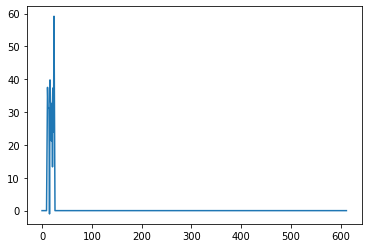

In [16]:
plt.plot(range(612), cumulative_rewards)

In [17]:
env.close()
print("Closed environment")

Closed environment


In [6]:
!pip install matplotlib

     |████████████████████████████████| 7.2 MB 743 kB/s eta 0:00:01
     |████████████████████████████████| 61 kB 441 kB/s eta 0:00:011
